In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [2]:
df = pd.read_csv('data/airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')

In [3]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [4]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [5]:
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

C:\Users\veren\AppData\Local\Temp\ipykernel_26084\778121417.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_fakvb73nko\croot\pytorch-select_1730848725921\work\torch\csrc\utils\tensor_new.cpp:277.)
  return torch.tensor(X), torch.tensor(y)


In [6]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [7]:
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [8]:
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 225.8151, test RMSE 425.0692
Epoch 100: train RMSE 178.5877, test RMSE 375.5229
Epoch 200: train RMSE 142.6158, test RMSE 336.2404
Epoch 300: train RMSE 113.0551, test RMSE 301.3431
Epoch 400: train RMSE 90.6754, test RMSE 270.9522
Epoch 500: train RMSE 69.2486, test RMSE 238.5725
Epoch 600: train RMSE 54.7762, test RMSE 211.5929
Epoch 700: train RMSE 43.6551, test RMSE 186.3260
Epoch 800: train RMSE 35.9567, test RMSE 164.6539
Epoch 900: train RMSE 30.7930, test RMSE 145.8030
Epoch 1000: train RMSE 27.3439, test RMSE 130.5426
Epoch 1100: train RMSE 25.1314, test RMSE 118.0437
Epoch 1200: train RMSE 23.5636, test RMSE 108.2720
Epoch 1300: train RMSE 22.6661, test RMSE 100.4759
Epoch 1400: train RMSE 21.7657, test RMSE 94.5253
Epoch 1500: train RMSE 21.2094, test RMSE 89.7142
Epoch 1600: train RMSE 20.5595, test RMSE 84.8947
Epoch 1700: train RMSE 20.7322, test RMSE 81.4818
Epoch 1800: train RMSE 19.8419, test RMSE 79.5030
Epoch 1900: train RMSE 19.4925, test RMSE 77

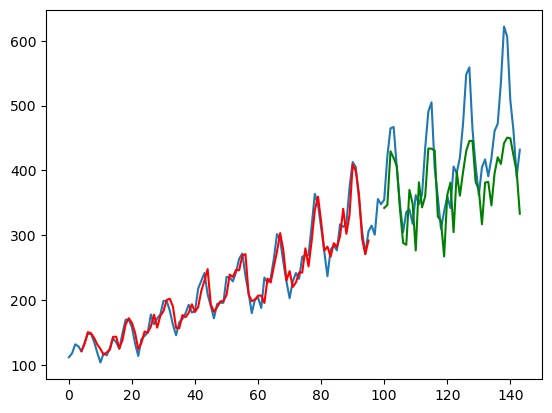

In [9]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()


In [92]:
from phased_lstm import PhasedLSTM, PhasedLSTMCell

In [115]:
class AirModelPhased(nn.Module):
    def __init__(self, input_size, hidden_size, bidirectional=True):
        super().__init__()
        self.phased_lstm = PhasedLSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), 1)
    def forward(self, x):
        lstm_out = self.phased_lstm(x)  # Output von PhasedLSTM
        #lstm_out = lstm_out[:,-1,:]
        out = self.fc(lstm_out)
        return out

In [116]:
model = AirModelPhased(input_size=0, hidden_size = 50)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [83]:
X_train.shape[2]-1

0

In [114]:
y_batch.shape

torch.Size([8, 4, 1])

In [118]:
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 112.9066, test RMSE 301.9429
Epoch 100: train RMSE 77.2597, test RMSE 247.2279
Epoch 200: train RMSE 71.0659, test RMSE 223.8316
Epoch 300: train RMSE 70.7813, test RMSE 217.9912
Epoch 400: train RMSE 70.7064, test RMSE 217.6297
Epoch 500: train RMSE 70.3736, test RMSE 217.5974
Epoch 600: train RMSE 70.4048, test RMSE 217.2633
Epoch 700: train RMSE 70.2065, test RMSE 217.5154
Epoch 800: train RMSE 70.3248, test RMSE 217.2139
Epoch 900: train RMSE 68.6503, test RMSE 216.4272
Epoch 1000: train RMSE 68.4589, test RMSE 214.6607
Epoch 1100: train RMSE 68.0085, test RMSE 213.5129
Epoch 1200: train RMSE 68.0826, test RMSE 212.1009
Epoch 1300: train RMSE 67.7292, test RMSE 212.2672
Epoch 1400: train RMSE 67.9004, test RMSE 210.5544
Epoch 1500: train RMSE 68.1470, test RMSE 211.4158
Epoch 1600: train RMSE 68.4574, test RMSE 211.4225
Epoch 1700: train RMSE 67.8716, test RMSE 211.4678
Epoch 1800: train RMSE 68.1072, test RMSE 211.7615
Epoch 1900: train RMSE 67.6698, test RMSE 